## Data preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
# read images

datadir = 'data'
directory = ["negative", "positive"]

for folder in directory:
    path = os.path.join(datadir, folder)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        break

In [3]:
img_array.shape

(682, 1024)

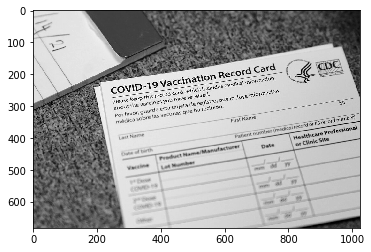

In [4]:
# Visualize the image
_ = plt.imshow(img_array, cmap="gray")
_ = plt.show

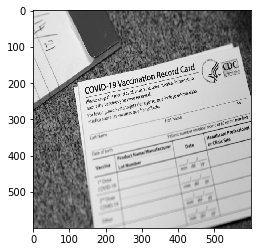

In [5]:
# Reduce the resolution of the images as needed
img_size=600
new_array = cv2.resize(img_array, (img_size, img_size))
plt.imshow(new_array, cmap='gray')
plt.show()

In [6]:
# Create your training data set
training_data=[]
img_size=300
def create_training_data():
    for folder in directory:
        path = os.path.join(datadir, folder)
        label = directory.index(folder)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size))
                training_data.append([new_array, label])
            except Exception as e:
                pass
create_training_data()

In [7]:
len(training_data)

1516

In [8]:
# size of the first image
training_data[0][0].shape

(300, 300)

In [9]:
# label of the first image
training_data[0][1]

0

In [10]:
# Shuffle them to get a good mix of different labels
import random
random.shuffle(training_data)

In [11]:
# View the mix after shuffling
for sample in training_data[:3]:
    print(sample[1])

0
1
0


In [12]:
# Seperate features and labels into separate arrays
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

In [13]:
X = np.array(X)
X = X/255
y = np.array(y)

In [14]:
X.shape

(1516, 300, 300)

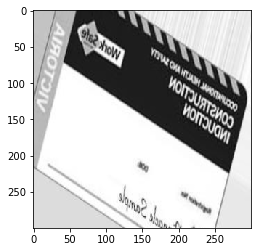

In [15]:
plt.imshow(X[0], cmap='gray')
plt.show()

In [16]:
y.shape

(1516,)

In [17]:
# reshape as required by Tensorlow/Keras
X = X.reshape(-1,img_size, img_size, 1)
y = np.array(y).reshape(-1,1)

In [216]:
# Save the data
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

OverflowError: cannot serialize a bytes object larger than 4 GiB

## Training

In [18]:
%matplotlib inline
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta
import math
import sys

In [19]:
# Confirm that TensorFlow can access the GPU
device_name = tf.test.gpu_device_name()
if not device_name:
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
with open('X.pickle', 'rb') as data:
    X = pickle.load(data)
    
with open('y.pickle', 'rb') as data:
    y = pickle.load(data)

In [87]:
X.shape

(1516, 300, 300, 1)

In [21]:
y.shape

(1516, 1)

In [56]:
X.dtype, y.dtype

(dtype('float32'), dtype('int32'))

In [23]:
X = X.astype('float32')

In [137]:
# We know that the images are 100 pixels by 100 pixels
img_size = 300

# Images are stored in one-dimensional arrays of this length
img_size_flat = img_size*img_size

# Height and width of each image in Tuple
img_shape = (img_size, img_size)

# Number of color channels for the image
num_channels = 1

# Number of classes - two classes, positive or negative
num_classes = 2

In [138]:
# Convolutional layer 1
filter1_size = 3  #Convolution filters are 3 x 3 pixels
num_filters1 = 8 

# Convolutional layer 2
filter2_size = 3 #Convolution filters are 5 x 5 pixels
num_filters2 = 16 

# Pooling
window_size = 2 #Pooling window 2x2
window_stride = 2 #Move by 2 strides

# Fully-connected layer
fc_size=1024     # Number of nodes in the fully-connected layer

# Convolution stride
conv_stride=1

In [139]:
X.shape, y.shape

((1516, 300, 300, 1), (1516, 1))

In [145]:
# Split the dataset into 70% vs 30% train and test sets
border = int(0.7*X.shape[0])
X_train = X[:border]
X_test = X[border:]
y_train = y[:border]
y_test = y[border:]

In [146]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1061, 300, 300, 1), (455, 300, 300, 1), (1061, 1), (455, 1))

In [147]:
def weights(shape):
    weights = tf.Variable(tf.random.normal(shape=shape, stddev=0.05))
    return weights

In [148]:
# Conv Layer1
shape_1 = [filter1_size, filter1_size, num_channels, num_filters1]
shape_bias1 = [num_channels, img_size, img_size, num_filters1]
conv1_weights = weights(shape_1)
bias_1 = tf.Variable(tf.ones(shape=shape_bias1))

def ConvNet1(image):
    # Conv1 layer
    conv1 = tf.nn.conv2d(input=image, filters=conv1_weights, strides=conv_stride, padding='SAME')
    conv1+=bias_1
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(input=conv1, ksize=window_size, strides=window_stride, padding='SAME')
    return conv1

In [149]:
conv1 = ConvNet1(X_train)
conv1.shape

TensorShape([1061, 150, 150, 8])

In [150]:
# Conv layer 2
shape_2 = [filter2_size, filter2_size, num_filters1, num_filters2]
shape_bias2 = [num_channels, img_size//2, img_size//2, num_filters2]
conv2_weights = weights(shape_2)
bias_2 = tf.Variable(tf.ones(shape=shape_bias2))

In [151]:
def ConvNet2(conv1):
    # Conv2 Layer
    conv2 = tf.nn.conv2d(input=conv1, filters=conv2_weights, strides=conv_stride, padding='SAME')
    conv2+=bias_2
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.max_pool(input=conv2, ksize=window_size, strides=window_stride, padding='SAME')
    return conv2

In [152]:
conv2 = ConvNet2(conv1)
conv2.shape

TensorShape([1061, 75, 75, 16])

In [153]:
# flatten
def flatten_layer(conv2):
    layer_shape = conv2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    flat_layer = tf.reshape(conv2, [-1, num_features])
    return flat_layer, num_features

In [154]:
flat, features = flatten_layer(conv2)
features, flat.shape

(90000, TensorShape([1061, 90000]))

In [155]:
# Fully connected layer
num_features=90000
fc_shape = [num_features, fc_size]
fc_weights = tf.Variable(tf.random.normal(shape=fc_shape))
bias_fc = tf.Variable(tf.ones([fc_size]))
# Output layer
shape_out = [fc_size, num_classes]
w_out = tf.Variable(tf.random.normal(shape=shape_out))
b_out = tf.Variable(tf.ones([num_classes]))

In [156]:
fc_weights.shape

TensorShape([90000, 1024])

In [157]:
def make_prediction(flat_layer, fc_weights, bias_fc, w_out, b_out):
    #Fully connected layer
    fc_product = tf.matmul(flat_layer, fc_weights)
    fully_connected = tf.keras.activations.relu(fc_product+bias_fc)
    fc_drop = tf.nn.dropout(fully_connected, rate=0.5, seed=1) # Drop 70% of the input elements randomly
    # Output layer
    output = tf.matmul(fc_drop, w_out)
    prediction = tf.keras.activations.softmax(output + b_out)
    return prediction

In [158]:
def model(image):
    conv1 = ConvNet1(image)
    conv2 = ConvNet2(conv1)
    flat_layer, num_features = flatten_layer(conv2)
    predictions = make_prediction(flat_layer, fc_weights, bias_fc, w_out, b_out)
    return predictions

In [159]:
# Train
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [160]:
# Instantiate a loss function.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [161]:
# Prepare the metrics.
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [168]:
# Package the data into batches
batch_size=64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(32).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).shuffle(32).batch(batch_size)

In [172]:
import time

training_loss_values=[]
training_accuracy_values=[]
test_accuracy_values=[]

start = time.time()
epochs = 100
for epoch in range(epochs):
    print("\nEpoch: {}/{}".format(epoch+1, epochs))
    

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_ds):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)
            

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, [fc_weights, bias_fc, w_out, b_out])

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, [fc_weights, bias_fc, w_out, b_out]))
        
        # Update training metric.
        train_acc_metric.update_state(y_batch_train, logits)
        
        # Log every 1874 batches.
        if step%16 == 0 and step!=0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * 16))
            
         # Display metrics at the end of every 1874 batch
        if step%16==0 and step!=0:
            train_acc = train_acc_metric.result()
            print("Training acc (for one batch): %.4f" % (float(train_acc),))

    # Run a test loop at the end of each epoch.
    for step, (x_batch_test, y_batch_test) in enumerate(test_ds):
        predictions = model(x_batch_test)
        #Update test metrics
        test_acc_metric.update_state(y_batch_test, predictions)
        if step%8==0 and step!=0:
            test_acc = test_acc_metric.result()
            print("Test acc: %.4f" % (float(test_acc),))
    
    training_loss_values.append(float(loss_value))
    training_accuracy_values.append(float(train_acc_metric.result()))
    test_accuracy_values.append(float(test_acc_metric.result()))
    # Reset metrics at the end of each epoch
    train_acc_metric.reset_states()
    test_acc_metric.reset_states()
    
print("Time taken: %.2fs" % (time.time() - start))  


Epoch: 1/100
Training loss (for one batch) at step 16: 0.6749
Seen so far: 272 samples
Training acc (for one batch): 0.5278

Epoch: 2/100
Training loss (for one batch) at step 16: 0.6840
Seen so far: 272 samples
Training acc (for one batch): 0.5278

Epoch: 3/100
Training loss (for one batch) at step 16: 0.6778
Seen so far: 272 samples
Training acc (for one batch): 0.5278

Epoch: 4/100
Training loss (for one batch) at step 16: 0.6901
Seen so far: 272 samples
Training acc (for one batch): 0.5278

Epoch: 5/100
Training loss (for one batch) at step 16: 0.6870
Seen so far: 272 samples
Training acc (for one batch): 0.5278

Epoch: 6/100
Training loss (for one batch) at step 16: 0.6808
Seen so far: 272 samples
Training acc (for one batch): 0.5278

Epoch: 7/100
Training loss (for one batch) at step 16: 0.6964
Seen so far: 272 samples
Training acc (for one batch): 0.5278

Epoch: 8/100
Training loss (for one batch) at step 16: 0.6839
Seen so far: 272 samples
Training acc (for one batch): 0.5278


KeyboardInterrupt: 

In [136]:
# Loss
loss_fn(y_test, model(X_test))

<tf.Tensor: shape=(), dtype=float32, numpy=1.3608807>

In [125]:
# Calculate accuracy by hand
sum(tf.argmax(model(X_test), axis=1).numpy().reshape(-1,1)==y_test)/y_test.shape[0]

array([0.72691293])

In [126]:
# Calculate Precision
sum(y_test==0)/sum(tf.argmax(model(X_test), axis=1).numpy().reshape(-1,1)==0)

array([1.72682927])

In [127]:
len(training_loss_values), len(training_accuracy_values), len(test_accuracy_values)

(100, 100, 100)

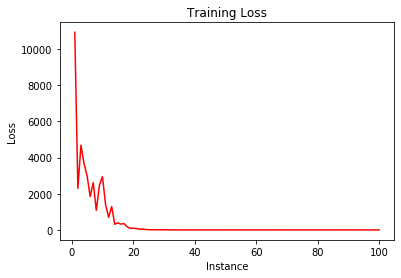

In [128]:
_ = plt.plot(range(1,len(training_loss_values)+1), np.array(training_loss_values), 'r')
_ = plt.xlabel("Instance")
_ = plt.ylabel("Loss")
_ = plt.title("Training Loss")
plt.show()

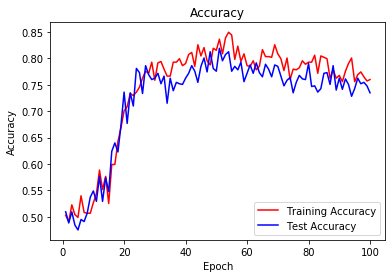

In [129]:
_ = plt.plot(range(1,len(training_accuracy_values)+1), np.array(training_accuracy_values), 'r', label='Training Accuracy')
_ = plt.plot(range(1,len(test_accuracy_values)+1), np.array(test_accuracy_values), 'b', label="Test Accuracy")
_ = plt.xlabel("Epoch")
_ = plt.ylabel("Accuracy")
_ = plt.title("Accuracy")
_ = plt.legend(loc='best')
plt.show()